# Replication of paper

- "Blended RAG: Improving RAG (Retriever-Augmented Generation) Accuracy with Semantic Search and Hybrid Query-Based Retrievers"
-  Link: [https://arxiv.org/pdf/2404.07220](https://arxiv.org/pdf/2404.07220)



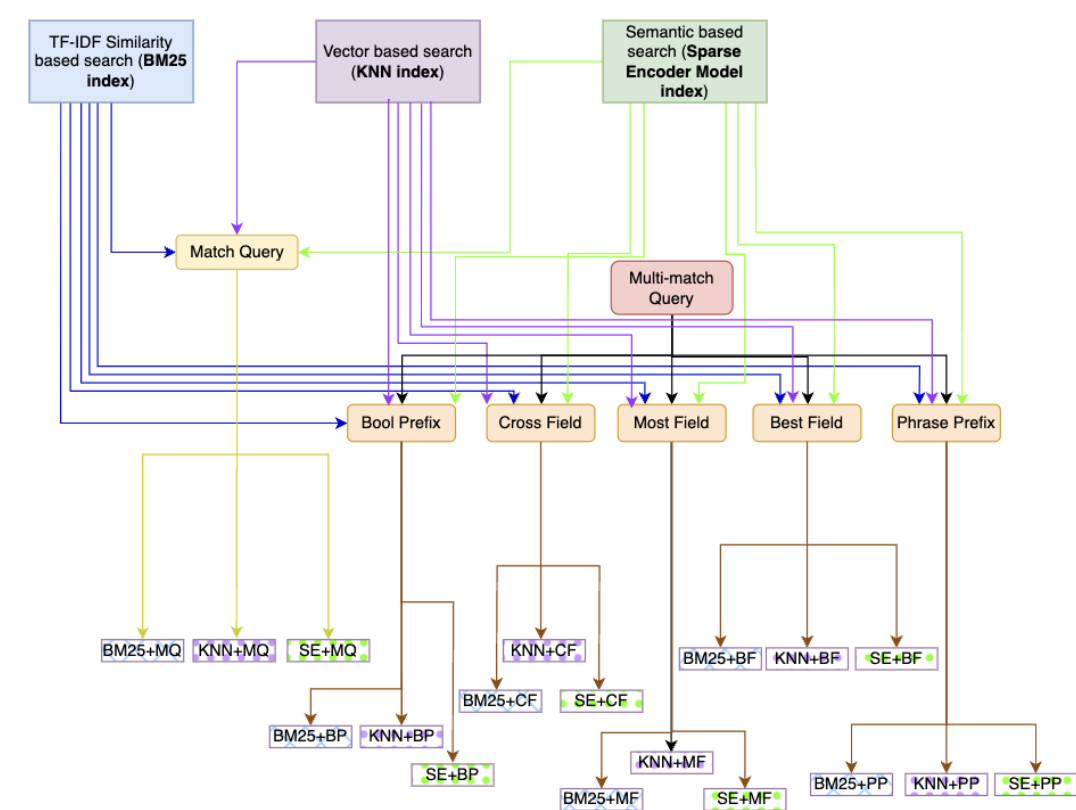

In [1]:
from IPython.display import Image
from IPython.display import display
display(Image(filename='fig.png'))


## setting up the Elastic search framework

In [2]:
##docker run --rm -p 9200:9200 -p 9300:9300 -e "xpack.security.enabled=false" -e "discovery.type=single-node" -e "ES_JAVA_OPTS=-Xms2g -Xmx4g" --cpus=2 -m 20g docker.elastic.co/elasticsearch/elasticsearch:8.3.3

In [3]:
!curl -X GET "localhost:9200/_cluster/health?pretty"

{
  "cluster_name" : "docker-cluster",
  "status" : "green",
  "timed_out" : false,
  "number_of_nodes" : 1,
  "number_of_data_nodes" : 1,
  "active_primary_shards" : 0,
  "active_shards" : 0,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 0,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 100.0
}


In [4]:
from elasticsearch import Elasticsearch
es= Elasticsearch("http://localhost:9200")
es.info().body

{'name': '3ad3cbbab53f',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': '2fXD4SBSRqOCEhj_7a8myg',
 'version': {'number': '8.3.3',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': '801fed82df74dbe537f89b71b098ccaff88d2c56',
  'build_date': '2022-07-23T19:30:09.227964828Z',
  'build_snapshot': False,
  'lucene_version': '9.2.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [5]:
es.indices.get_alias(index="*")

ObjectApiResponse({})

In [6]:
# Delete the extra indices
extra_indices = ['v2_sparse_index','v2_squad_sparse_index', 'v2_knn', 'v2_bm25_index','squad_index','sparse_encoder_index','knn_index','bm25_index','research_index_elser','research_index_bm25','research_index_knn']


for index in extra_indices:
    if es.indices.exists(index=index):
        es.indices.delete(index=index)
        print(f"Deleted index: {index}")
    else:
        print(f"Index '{index}' does not exist.")
        
        
        

Index 'v2_sparse_index' does not exist.
Index 'v2_squad_sparse_index' does not exist.
Index 'v2_knn' does not exist.
Index 'v2_bm25_index' does not exist.
Index 'squad_index' does not exist.
Index 'sparse_encoder_index' does not exist.
Index 'knn_index' does not exist.
Index 'bm25_index' does not exist.
Index 'research_index_elser' does not exist.
Index 'research_index_bm25' does not exist.
Index 'research_index_knn' does not exist.


In [7]:
es.indices.get_alias(index="*")

ObjectApiResponse({})

## Introduction of SQuAD dataset

In [8]:
 from datasets import load_dataset
#The Stanford Question Answering Dataset (SQuAD)consists of over 100,000 questions posed on a set of 
#Wikipedia articles, where the answer to each question is a span of text from the corresponding article. 
#The dataset is widely used for developing and benchmarking models for tasks like reading comprehension and open-domain question answering.

# Load  only 5% subset of SQuAD dataset to save space in my local system
dataset = load_dataset('squad', split='train[:3%]')  
dataset.save_to_disk('/home/user/Desktop/project/v2/data/raw/squad_subset')

Found cached dataset parquet (/home/user/.cache/huggingface/datasets/parquet/plain_text-7d14fdbf55ecc00c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Saving the dataset (0/1 shards):   0%|          | 0/2628 [00:00<?, ? examples/s]

In [9]:
from datasets import load_dataset

# Get the number of examples (size of the dataset)
dataset_size = len(dataset)

# Get the column names (shape of the dataset)
dataset_shape = dataset.column_names

# Display the size and shape
print(f"Dataset size: {dataset_size} examples")
print(f"Dataset shape (columns): {dataset_shape}")

Dataset size: 2628 examples
Dataset shape (columns): ['id', 'title', 'context', 'question', 'answers']


In [10]:
# Print 5 samples from the dataset
for i, sample in enumerate(dataset.select(range(5))):
    print(f"Sample {i+1}:")
    print(sample)
    print("\n---\n")


Sample 1:
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

---

Sample 2:
{'id': '5733be284776f4190066

## BM25 index

### Create the index with the adjusted mapping 

In [11]:
from elasticsearch import Elasticsearch, helpers
import datasets

# Load the SQuAD dataset
squad_dataset = datasets.load_from_disk('/home/user/Desktop/project/v2/data/raw/squad_subset')

# Define the index name
index_name = "v2_bm25_index"

# adapted from bm25.txt maping, Blende RAG Git reporsitory:
#https://github.com/ibm-ecosystem-engineering/Blended-RAG/blob/main/input/mapping/bm25.txt

index_mapping = {
    "settings": {
        "number_of_replicas": 0,
        "number_of_shards": 1,
        "refresh_interval": "1m",
        "analysis": {
            "filter": {
                "possessive_english_stemmer": {
                    "type": "stemmer",
                    "language": "possessive_english"
                },
                "light_english_stemmer": {
                    "type": "stemmer",
                    "language": "light_english"
                },
                "english_stop": {
                    "ignore_case": "true",
                    "type": "stop",
                    "stopwords": ["a", "about", "all", "also", "am", "an", "and", "any", "are", "as", "at",
                                  "be", "been", "but", "by", "can", "de", "did", "do", "does", "for", "from",
                                  "had", "has", "have", "he", "her", "him", "his", "how", "if", "in", "into",
                                  "is", "it", "its", "more", "my", "nbsp", "new", "no", "non", "not", "of",
                                  "on", "one", "or", "other", "our", "she", "so", "some", "such", "than",
                                  "that", "the", "their", "then", "there", "these", "they", "this", "those",
                                  "thus", "to", "up", "us", "use", "was", "we", "were", "what", "when", "where",
                                  "which", "while", "why", "will", "with", "would", "you", "your", "yours"]
                }
            },
            "analyzer": {
                "text_en_no_stop": {
                    "filter": [
                        "lowercase",
                        "possessive_english_stemmer",
                        "light_english_stemmer"
                    ],
                    "tokenizer": "standard"
                },
                "text_en_stop": {
                    "filter": [
                        "lowercase",
                        "possessive_english_stemmer",
                        "english_stop",
                        "light_english_stemmer"
                    ],
                    "tokenizer": "standard"
                },
                "whitespace_lowercase": {
                    "tokenizer": "whitespace",
                    "filter": [
                        "lowercase"
                    ]
                }
            },
            "normalizer": {
                "keyword_lowercase": {
                    "filter": [
                        "lowercase"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "title": {"type": "text"},
            "context": {"type": "text"},  # Changed from 'story' in to 'context'
            "question": {"type": "text"},  # Added 'question' field
            "answers": {"type": "text"}  # Added 'answers' field
        }
    }
}

# Create the index with the adjusted mapping
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=index_mapping)
    
    
print("BM25_DONE!")

BM25_DONE!


### Indexing documents with BM25 index


In [12]:
# Prepare documents for bulk indexing
def generate_actions(dataset):
    for i, record in enumerate(dataset):
        yield {
            "_index": index_name,
            "_id": i,
            "_source": {
                "id": record['id'],
                "title": record['title'],
                "context": record['context'],
                "question": record['question'],
                "answers": record['answers']['text'][0]  # Example: first answer
            }
        }

helpers.bulk(es, generate_actions(squad_dataset))


print("Indexing completed.")


Indexing completed.


### Verify Document in the Index:

In [13]:
es.indices.get_alias(index="*")

ObjectApiResponse({'v2_bm25_index': {'aliases': {}}})

In [14]:
doc_count = es.count(index=index_name)['count']
print(f"Document count for index '{index_name}': {doc_count}")

Document count for index 'v2_bm25_index': 0


In [15]:
#By default, Elasticsearch does not immediately make newly indexed documents visible for search; instead, 
#it waits for a refresh to occur.
es.indices.refresh(index=index_name)

ObjectApiResponse({'_shards': {'total': 1, 'successful': 1, 'failed': 0}})

In [16]:
doc_count = es.count(index=index_name)['count']
print(f"Document count for index '{index_name}': {doc_count}")

Document count for index 'v2_bm25_index': 2628


In [17]:
document_id =  2610
response = es.get(index=index_name, id=document_id)
print(response['_source'])


{'id': '56cc858b6d243a140015efe9', 'title': 'IPod', 'context': 'The iPod line can play several audio file formats including MP3, AAC/M4A, Protected AAC, AIFF, WAV, Audible audiobook, and Apple Lossless. The iPod photo introduced the ability to display JPEG, BMP, GIF, TIFF, and PNG image file formats. Fifth and sixth generation iPod Classics, as well as third generation iPod Nanos, can additionally play MPEG-4 (H.264/MPEG-4 AVC) and QuickTime video formats, with restrictions on video dimensions, encoding techniques and data-rates. Originally, iPod software only worked with Mac OS; iPod software for Microsoft Windows was launched with the second generation model. Unlike most other media players, Apple does not support Microsoft\'s WMA audio format—but a converter for WMA files without Digital Rights Management (DRM) is provided with the Windows version of iTunes. MIDI files also cannot be played, but can be converted to audio files using the "Advanced" menu in iTunes. Alternative open-so

In [18]:
search_query = {
    "query": {
        "term": {
            "id": "5733be284776f4190066117e"
        }
    }
}
response = es.search(index=index_name, body=search_query)
for hit in response['hits']['hits']:
    print(hit['_source'])


{'id': '5733be284776f4190066117e', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'What sits on top of the Main Building at Notre Dame?', 'answers': 'a golden statue of the Virgin Mary'}


In [19]:
# Get index mapping to understand the document structure
mapping = es.indices.get_mapping(index=index_name)
print(mapping)

{'v2_bm25_index': {'mappings': {'properties': {'answers': {'type': 'text'}, 'context': {'type': 'text'}, 'id': {'type': 'text'}, 'question': {'type': 'text'}, 'title': {'type': 'text'}}}}}


## knn

### Creating the index with the adjusted mapping

In [20]:
from sentence_transformers import SentenceTransformer

# Define the index name
index_name = "v2_knn"

# Define the index mapping for kNN
index_mapping = {
    "settings": {
        "number_of_replicas": 0,
        "number_of_shards": 1,
        "refresh_interval": "1m",
        "analysis": {
            "filter": {
                "possessive_english_stemmer": {
                    "type": "stemmer",
                    "language": "possessive_english"
                },
                "light_english_stemmer": {
                    "type": "stemmer",
                    "language": "light_english"
                },
                "english_stop": {
                    "ignore_case": "true",
                    "type": "stop",
                    "stopwords": ["a", "about", "all", "also", "am", "an", "and", "any", "are", "as", "at",
                                  "be", "been", "but", "by", "can", "de", "did", "do", "does", "for", "from",
                                  "had", "has", "have", "he", "her", "him", "his", "how", "if", "in", "into",
                                  "is", "it", "its", "more", "my", "nbsp", "new", "no", "non", "not", "of",
                                  "on", "one", "or", "other", "our", "she", "so", "some", "such", "than",
                                  "that", "the", "their", "then", "there", "these", "they", "this", "those",
                                  "thus", "to", "up", "us", "use", "was", "we", "were", "what", "when", "where",
                                  "which", "while", "why", "will", "with", "would", "you", "your", "yours"]
                }
            },
            "analyzer": {
                "text_en_no_stop": {
                    "filter": ["lowercase", "possessive_english_stemmer", "light_english_stemmer"],
                    "tokenizer": "standard"
                },
                "text_en_stop": {
                    "filter": ["lowercase", "possessive_english_stemmer", "english_stop", "light_english_stemmer"],
                    "tokenizer": "standard"
                },
                "whitespace_lowercase": {
                    "tokenizer": "whitespace",
                    "filter": ["lowercase"]
                }
            },
            "normalizer": {
                "keyword_lowercase": {
                    "filter": ["lowercase"]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "id": {"type": "text"},
            "title": {"type": "text"},
            "context": {"type": "text"},
            "question": {"type": "text"},
            "answers": {"type": "text"},
            "story_embedding": {
                "type": "dense_vector", 
                "dims": 384, 
                "similarity": "cosine",
                "index": "true"
            }
        }
    }
}

# Create the index with the adjusted mapping
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=index_mapping)

print("KNN_DONE!")


KNN_DONE!


### Indexing documents with knn index

In [21]:
# Load pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embedding(text):
    """Generate an embedding for the given text using SentenceTransformer."""
    return model.encode(text).tolist()  # Convert numpy array to list for Elasticsearch compatibility

# Prepare documents for bulk indexing
def generate_actions(dataset):
    for record in dataset:
        yield {
            "_index": index_name,
            "_id": record['id'],
            "_source": {
                "id": record['id'],
                "title": record['title'],
                "context": record['context'],
                "question": record['question'],
                "answers": record['answers']['text'][0],  # Example: first answer
                "story_embedding": generate_embedding(record['context'])  # Generate and add embedding
            }
        }

# Index documents using bulk helper
helpers.bulk(es, generate_actions(squad_dataset))

print("Indexing completed.")

Indexing completed.


### Verify Document in the Index:

In [22]:
'''''
# Example usage
text = "This is an example sentence."
vector = generate_embedding(text)
print(vector)
'''''

'\'\'\n# Example usage\ntext = "This is an example sentence."\nvector = generate_embedding(text)\nprint(vector)\n'

In [23]:
es.indices.get_alias(index="*")

ObjectApiResponse({'v2_bm25_index': {'aliases': {}}, 'v2_knn': {'aliases': {}}})

In [24]:
doc_count = es.count(index=index_name)['count']
print(f"Document count for index '{index_name}': {doc_count}")

Document count for index 'v2_knn': 1500


In [25]:
search_query = {
    "query": {
        "term": {
            "id": "5733be284776f4190066117e"
        }
    }
}
response = es.search(index=index_name, body=search_query)
for hit in response['hits']['hits']:
    print(hit['_source'])


{'id': '5733be284776f4190066117e', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'What sits on top of the Main Building at Notre Dame?', 'answers': 'a golden statue of the Virgin Mary', 'story_embedding': [0.02879420295357704, 0.14770705997943878, 0.003612995147705078, 0.01307190675288

## Elastic Learned Sparse Encoder (ELSER) index 

### Create the index with the adjusted mapping 

In [26]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

# Define the index name
index_name = "v2_sparse_index"

index_mapping = {
    "settings": {
        "number_of_replicas": 0,
        "number_of_shards": 1,
        "refresh_interval": "1m",
        "analysis": {
            "filter": {
                "possessive_english_stemmer": {
                    "type": "stemmer",
                    "language": "possessive_english"
                },
                "light_english_stemmer": {
                    "type": "stemmer",
                    "language": "light_english"
                },
                "english_stop": {
                    "ignore_case": "true",
                    "type": "stop",
                    "stopwords": ["a", "about", "all", "also", "am", "an", "and", "any", "are", "as", "at",
                                  "be", "been", "but", "by", "can", "de", "did", "do", "does", "for", "from",
                                  "had", "has", "have", "he", "her", "him", "his", "how", "if", "in", "into",
                                  "is", "it", "its", "more", "my", "nbsp", "new", "no", "non", "not", "of",
                                  "on", "one", "or", "other", "our", "she", "so", "some", "such", "than",
                                  "that", "the", "their", "then", "there", "these", "they", "this", "those",
                                  "thus", "to", "up", "us", "use", "was", "we", "were", "what", "when", "where",
                                  "which", "while", "why", "will", "with", "would", "you", "your", "yours"]
                }
            },
            "analyzer": {
                "text_en_no_stop": {
                    "filter": [
                        "lowercase",
                        "possessive_english_stemmer",
                        "light_english_stemmer"
                    ],
                    "tokenizer": "standard"
                },
                "text_en_stop": {
                    "filter": [
                        "lowercase",
                        "possessive_english_stemmer",
                        "english_stop",
                        "light_english_stemmer"
                    ],
                    "tokenizer": "standard"
                },
                "whitespace_lowercase": {
                    "tokenizer": "whitespace",
                    "filter": [
                        "lowercase"
                    ]
                }
            },
            "normalizer": {
                "keyword_lowercase": {
                    "filter": [
                        "lowercase"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "id": {"type": "keyword"},  # 'id' should be a keyword for exact matches
            "context": {"type": "text", "analyzer": "text_en_no_stop"},  # Corresponds to 'context' in SQuAD
            "question": {"type": "text", "analyzer": "text_en_no_stop"},  # Corresponds to 'question' in SQuAD
            "answers": {
                "properties": {
                    "text": {"type": "text"},
                    "answer_start": {"type": "integer"}
                }
            },
             "ml_tokens": {
                "type": "object",
                "properties": {
                    "tokens": {
                        "type": "text",  # or "keyword" depending on your needs
                        "fields": {
                            "count": {"type": "float"}
            }
        }
    }
},
            "sparse_features": {
                "type": "dense_vector",
                "dims": 768  # Adjust this according to the actual dimension of your embeddings
            }
        }
    }
}

# Create the index
es.indices.create(index=index_name, body=index_mapping)
print(f"Index '{index_name}' created successfully.")


Index 'v2_sparse_index' created successfully.


### Indexing documents with Sparse index

In [27]:
from datetime import datetime
start_time = datetime.now()



def generate_actions(squad_dataset):
    for record in squad_dataset:
        ml_tokens = generate_rank_features(record['context'])
        ml_tokens_list = [{"token": k, "count": v} for k, v in ml_tokens.items()]
        yield {
            "_index": index_name,
            "_id": record['id'],
            "_source": {
                "id": record['id'],
                "context": record['context'],
                "question": record['question'],
                "answers": record['answers'],
                "ml_tokens": ml_tokens_list,  # Ensure this matches the index mapping
                "sparse_features": sparse_vector_model(record['context'])
            }
        }
        
# Example of generating rank features
def generate_rank_features(text):
    tokens = text.lower().split()
    rank_features = {}
    for token in tokens:
        rank_features[token] = rank_features.get(token, 0) + 1.0
    return rank_features

# Example of generating sparse vector (assuming `sparse_vector_model` is defined)
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def sparse_vector_model(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    sentence_embedding = last_hidden_state.mean(dim=1)
    sparse_vector = sentence_embedding.squeeze().tolist()
    return sparse_vector




from elasticsearch.helpers import bulk, BulkIndexError
try:
    helpers.bulk(es,  generate_actions(squad_dataset))
except BulkIndexError as e:
    for error in e.errors[:10]:
        print(error)
                
     

    
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))    

# Perform bulk indexing
#bulk(es, generate_actions(squad_dataset))
#print("Bulk indexing completed.")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Duration: 0:08:20.938353


### Verify Document in the Index

In [28]:
es.indices.get_alias(index="*")

ObjectApiResponse({'v2_sparse_index': {'aliases': {}}, 'v2_bm25_index': {'aliases': {}}, 'v2_knn': {'aliases': {}}})

In [29]:
es.indices.refresh(index=index_name)

ObjectApiResponse({'_shards': {'total': 1, 'successful': 1, 'failed': 0}})

In [30]:
doc_count = es.count(index=index_name)['count']
print(f"Document count for index '{index_name}': {doc_count}")

Document count for index 'v2_sparse_index': 2628


In [31]:
search_query = {
    "query": {
        "term": {
            "id": "5733be284776f4190066117e"
        }
    }
}
response = es.search(index=index_name, body=search_query)
for hit in response['hits']['hits']:
    print(hit['_source'])

{'id': '5733be284776f4190066117e', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'What sits on top of the Main Building at Notre Dame?', 'answers': {'text': ['a golden statue of the Virgin Mary'], 'answer_start': [92]}, 'ml_tokens': [{'token': 'architecturally,', 'count': 1.0}, {'token': 'the', 'count': 15.0}, {'token': '

## Hybrid Query-Based Retrievers


In [32]:
# Index names
bm25_index = "v2_bm25_index"
knn_index = "v2_knn"
sparse_encoder_index = "v2_sparse_index"

# Get document counts for each index
def get_document_count(index_name):
    count = es.count(index=index_name)['count']
    return count

# Report document counts
bm25_count = get_document_count(bm25_index)
knn_count = get_document_count(knn_index)
sparse_encoder_count = get_document_count(sparse_encoder_index)

print(f"BM25 Index Document Count: {bm25_count}")
print(f"KNN Index Document Count: {knn_count}")
print(f"Sparse Encoder Index Document Count: {sparse_encoder_count}")

BM25 Index Document Count: 2628
KNN Index Document Count: 2628
Sparse Encoder Index Document Count: 2628


In [33]:
def query_index(index_name, query_text, field="context"):
    # Simple match query
    query_body = {
        "query": {
            "match": {
                field: query_text
            }
        }
    }
    # Search the index
    results = es.search(index=index_name, body=query_body)
    return results

# Example query
query_text = "What is the capital of France?"

# Run queries across the three indices
bm25_results = query_index(bm25_index, query_text)
knn_results = query_index(knn_index, query_text)
sparse_encoder_results = query_index(sparse_encoder_index, query_text)

# Display sample results
print(f"BM25 Query Results: {bm25_results['hits']['hits'][:3]}")
print(f"KNN Query Results: {knn_results['hits']['hits'][:3]}")
print(f"Sparse Encoder Query Results: {sparse_encoder_results['hits']['hits'][:3]}")

BM25 Query Results: [{'_index': 'v2_bm25_index', '_id': '138', '_score': 6.463134, '_source': {'id': '573398164776f41900660e21', 'title': 'University_of_Notre_Dame', 'context': "Because of its Catholic identity, a number of religious buildings stand on campus. The Old College building has become one of two seminaries on campus run by the Congregation of Holy Cross. The current Basilica of the Sacred Heart is located on the spot of Fr. Sorin's original church, which became too small for the growing college. It is built in French Revival style and it is decorated by stained glass windows imported directly from France. The interior was painted by Luigi Gregori, an Italian painter invited by Fr. Sorin to be artist in residence. The Basilica also features a bell tower with a carillon. Inside the church there are also sculptures by Ivan Mestrovic. The Grotto of Our Lady of Lourdes, which was built in 1896, is a replica of the original in Lourdes, France. It is very popular among students and

In [34]:
def summarize_results(results, top_k=3):
    summary = []
    for i, hit in enumerate(results['hits']['hits'][:top_k]):
        doc_id = hit['_id']
        score = hit['_score']
        source_excerpt = hit['_source']['context'][:50]  # Shorten the context to 50 characters
        summary.append(f"{i+1}. Score: {score}, Document ID: {doc_id}, Source Excerpt: {source_excerpt}...")
    return summary

# Summarize and print results for each index
bm25_summary = summarize_results(bm25_results)
knn_summary = summarize_results(knn_results)
sparse_encoder_summary = summarize_results(sparse_encoder_results)

print("BM25 Index Top Results Summary:")
for line in bm25_summary:
    print(line)

print("\nKNN Index Top Results Summary:")
for line in knn_summary:
    print(line)

print("\nSparse Encoder Index Top Results Summary:")
for line in sparse_encoder_summary:
    print(line)

BM25 Index Top Results Summary:
1. Score: 6.463134, Document ID: 138, Source Excerpt: Because of its Catholic identity, a number of reli...
2. Score: 6.463134, Document ID: 139, Source Excerpt: Because of its Catholic identity, a number of reli...
3. Score: 6.463134, Document ID: 140, Source Excerpt: Because of its Catholic identity, a number of reli...

KNN Index Top Results Summary:
1. Score: 6.463134, Document ID: 573398164776f41900660e21, Source Excerpt: Because of its Catholic identity, a number of reli...
2. Score: 6.463134, Document ID: 573398164776f41900660e22, Source Excerpt: Because of its Catholic identity, a number of reli...
3. Score: 6.463134, Document ID: 573398164776f41900660e23, Source Excerpt: Because of its Catholic identity, a number of reli...

Sparse Encoder Index Top Results Summary:
1. Score: 6.528357, Document ID: 56cbd2356d243a140015ed66, Source Excerpt: Frédéric François Chopin (/ˈʃoʊpæn/; French pronun...
2. Score: 6.528357, Document ID: 56cbd2356d243a140015

### Search_query_BM25 index

In [35]:
def search_bm25_phrase(question, index):
    query = {
        "query": {
            "multi_match": {
                "query": question,
                "type": "phrase_prefix",
                "fields": ["context^2", "title^1"]
            }
        }
    }
    print("BM25 Phrase Query:", query)  # Debug print
    response = es.search(index=index, body=query)
    print("BM25 Phrase Response:", response)  # Debug print
    return response['hits']['hits']

def search_bm25_match(question, index):
    query = {
        "query": {
            "match": {
                "context": {
                    "query": question,
                    "operator": "and"
                }
            }
        }
    }
    print("BM25 Match Query:", query)  # Debug print
    response = es.search(index=index, body=query)
    print("BM25 Match Response:", response)  # Debug print
    return response['hits']['hits']

def search_bm25_cross_fields(question, index):
    query = {
        "query": {
            "multi_match": {
                "query": question,
                "type": "cross_fields",
                "fields": ["context", "title"],
                "operator": "and",
                "tie_breaker": 0.3
            }
        }
    }
    print("BM25 Cross Fields Query:", query)  # Debug print
    response = es.search(index=index, body=query)
    print("BM25 Cross Fields Response:", response)  # Debug print
    return response['hits']['hits']

def search_bm25_most_fields(question, index):
    query = {
        "query": {
            "multi_match": {
                "query": question,
                "type": "most_fields",
                "fields": ["context", "title"],
                "operator": "and"
            }
        }
    }
    print("BM25 Most Fields Query:", query)  # Debug print
    response = es.search(index=index, body=query)
    print("BM25 Most Fields Response:", response)  # Debug print
    return response['hits']['hits']

def search_bm25_bool_prefix(question, index):
    query = {
        "query": {
            "multi_match": {
                "query": question,
                "type": "bool_prefix",
                "fields": ["context", "title"]
            }
        }
    }
    print("BM25 Bool Prefix Query:", query)  # Debug print
    response = es.search(index=index, body=query)
    print("BM25 Bool Prefix Response:", response)  # Debug print
    return response['hits']['hits']

def search_bm25_best_fields(question, index):
    query = {
        "query": {
            "multi_match": {
                "query": question,
                "type": "best_fields",
                "fields": ["context", "title"],
                "tie_breaker": 0.3
            }
        }
    }
    print("BM25 Best Fields Query:", query)  # Debug print
    response = es.search(index=index, body=query)
    print("BM25 Best Fields Response:", response)  # Debug print
    return response['hits']['hits']


# Example usage:
index_name = "v2_bm25_index"  
question = "What is the capital of France?"

# Perform different types of BM25 queries
results_phrase = search_bm25_phrase(question, index_name)
results_match = search_bm25_match(question, index_name)
results_cross_fields = search_bm25_cross_fields(question, index_name)
results_most_fields = search_bm25_most_fields(question, index_name)
results_bool_prefix = search_bm25_bool_prefix(question, index_name)
results_best_fields = search_bm25_best_fields(question, index_name)

# Print results
print("BM25 Phrase Query Results:", results_phrase)
print("BM25 Match Query Results:", results_match)
print("BM25 Cross Fields Query Results:", results_cross_fields)
print("BM25 Most Fields Query Results:", results_most_fields)
print("BM25 Bool Prefix Query Results:", results_bool_prefix)
print("BM25 Best Fields Query Results:", results_best_fields)

BM25 Phrase Query: {'query': {'multi_match': {'query': 'What is the capital of France?', 'type': 'phrase_prefix', 'fields': ['context^2', 'title^1']}}}
BM25 Phrase Response: {'took': 21, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}}
BM25 Match Query: {'query': {'match': {'context': {'query': 'What is the capital of France?', 'operator': 'and'}}}}
BM25 Match Response: {'took': 5, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}}
BM25 Cross Fields Query: {'query': {'multi_match': {'query': 'What is the capital of France?', 'type': 'cross_fields', 'fields': ['context', 'title'], 'operator': 'and', 'tie_breaker': 0.3}}}
BM25 Cross Fields Response: {'took': 5, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, '

### Search_query_KNN index

In [42]:
# Load pre-trained SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embedding(text):
    """Generate an embedding for the given text using SentenceTransformer."""
    return model.encode(text).tolist()  # Convert numpy array to list for Elasticsearch compatibility

def search_knn(query, index_name):
    query_vector = generate_embedding(query)
    knn_body = {
        "knn": {
            "field": "story_embedding",  # Correct field name
            "query_vector": query_vector,
            "k": 10,  # Number of nearest neighbors to retrieve
            "num_candidates": 100  # Number of candidates to consider
        }
    }
    headers = {"Content-Type": "application/json"}
    response = es.transport.perform_request("POST", f"/{index_name}/_knn_search", body=knn_body, headers=headers)
    return response

def search_phrase(query, index_name):
    query_body = {
        "query": {
            "multi_match": {
                "query": query,
                "type": "phrase_prefix",
                "fields": ["context", "title"]
            }
        }
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_match(query, index_name):
    query_body = {
        "query": {
            "match": {
                "context": {
                    "query": query
                }
            }
        }
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_best_fields(query, index_name):
    query_body = {
        "query": {
            "multi_match": {
                "query": query,
                "type": "best_fields",
                "fields": ["context", "title"],
                "tie_breaker": 0.3
            }
        }
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_most_fields(query, index_name):
    query_body = {
        "query": {
            "multi_match": {
                "query": query,
                "type": "most_fields",
                "fields": ["context", "title"]
            }
        }
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_bool_prefix(query, index_name):
    query_body = {
        "query": {
            "multi_match": {
                "query": query,
                "type": "bool_prefix",
                "fields": ["context", "title"]
            }
        }
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_cross_fields(query, index_name):
    query_body = {
        "query": {
            "multi_match": {
                "query": query,
                "type": "cross_fields",
                "fields": ["context", "title"],
                "tie_breaker": 0.3
            }
        }
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

# Example usage
index_name_knn = "v2_knn"  # Your KNN index name
query = "What is the capital of France?"

# Perform different types of queries
results_knn = search_knn(query, index_name_knn)
results_phrase = search_phrase(query, index_name_knn)
results_match = search_match(query, index_name_knn)
results_best_fields = search_best_fields(query, index_name_knn)
results_most_fields = search_most_fields(query, index_name_knn)
results_bool_prefix = search_bool_prefix(query, index_name_knn)
results_cross_fields = search_cross_fields(query, index_name_knn)

# Print results
print("KNN Query Results:", results_knn)
print("Phrase Query Results:", results_phrase)
print("Match Query Results:", results_match)
print("Best Fields Query Results:", results_best_fields)
print("Most Fields Query Results:", results_most_fields)
print("Bool Prefix Query Results:", results_bool_prefix)
print("Cross Fields Query Results:", results_cross_fields)


KNN Query Results: TransportApiResponse(meta=ApiResponseMeta(status=200, http_version='1.1', headers={'X-elastic-product': 'Elasticsearch', 'content-type': 'application/json', 'content-length': '89713'}, duration=0.03399324417114258, node=NodeConfig(scheme='http', host='localhost', port=9200, path_prefix='', headers={'user-agent': 'elasticsearch-py/8.14.0 (Python/3.7.13; elastic-transport/8.13.1)'}, connections_per_node=10, request_timeout=10.0, http_compress=False, verify_certs=True, ca_certs=None, client_cert=None, client_key=None, ssl_assert_hostname=None, ssl_assert_fingerprint=None, ssl_version=None, ssl_context=None, ssl_show_warn=True, _extras={})), body={'took': 24, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 100, 'relation': 'eq'}, 'max_score': 0.64074206, 'hits': [{'_index': 'v2_knn', '_id': '5733be284776f41900661182', '_score': 0.64074206, '_source': {'id': '5733be284776f41900661182', 'title': 'Universi

/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.

In [43]:
results_best_fields

ObjectApiResponse({'took': 6, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 2628, 'relation': 'eq'}, 'max_score': 6.463134, 'hits': [{'_index': 'v2_knn', '_id': '573398164776f41900660e21', '_score': 6.463134, '_source': {'id': '573398164776f41900660e21', 'title': 'University_of_Notre_Dame', 'context': "Because of its Catholic identity, a number of religious buildings stand on campus. The Old College building has become one of two seminaries on campus run by the Congregation of Holy Cross. The current Basilica of the Sacred Heart is located on the spot of Fr. Sorin's original church, which became too small for the growing college. It is built in French Revival style and it is decorated by stained glass windows imported directly from France. The interior was painted by Luigi Gregori, an Italian painter invited by Fr. Sorin to be artist in residence. The Basilica also features a bell tower with a carillon. Inside the c

### Search_query_Saprse Encoder index

In [44]:

def search_sparse_encoder_best_fields(question, index_name):
    query_body = {
        "query": {
            "bool": {
                "should": [
                    {
                        "match": {
                            "title": {
                                "query": question,
                                "boost": 2.0  # Boost for title field
                            }
                        }
                    },
                    {
                        "match": {
                            "context": {
                                "query": question
                            }
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "min_score": 1
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_sparse_encoder_phrase_prefix(question, index_name):
    query_body = {
        "query": {
            "bool": {
                "should": [
                    {
                        "match_phrase_prefix": {
                            "title": {
                                "query": question,
                                "boost": 2.0
                            }
                        }
                    },
                    {
                        "match_phrase_prefix": {
                            "context": {
                                "query": question
                            }
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "min_score": 1
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_sparse_encoder_match(question, index_name):
    query_body = {
        "query": {
            "bool": {
                "should": [
                    {
                        "match": {
                            "title": {
                                "query": question,
                                "boost": 2.0
                            }
                        }
                    },
                    {
                        "match": {
                            "context": {
                                "query": question
                            }
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "min_score": 1
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_sparse_encoder_cross_fields(question, index_name):
    query_body = {
        "query": {
            "bool": {
                "should": [
                    {
                        "multi_match": {
                            "query": question,
                            "type": "cross_fields",
                            "fields": ["title", "context"],
                            "boost": 1.0
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "min_score": 1
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_sparse_encoder_most_fields(question, index_name):
    query_body = {
        "query": {
            "bool": {
                "should": [
                    {
                        "multi_match": {
                            "query": question,
                            "type": "most_fields",
                            "fields": ["title", "context"]
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "min_score": 1
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

def search_sparse_encoder_bool_prefix(question, index_name):
    query_body = {
        "query": {
            "bool": {
                "should": [
                    {
                        "multi_match": {
                            "query": question,
                            "type": "bool_prefix",
                            "fields": ["title", "context"]
                        }
                    }
                ],
                "minimum_should_match": 1
            }
        },
        "min_score": 1
    }
    headers = {"Content-Type": "application/json"}
    return es.search(index=index_name, body=query_body, headers=headers)

# Example usage:
index_name_sparse_encoder = "v2_sparse_index"  # Your Sparse Encoder index name
question = "What is the capital of France?"

# Perform different types of Sparse Encoder queries
results_sparse_encoder_best_fields = search_sparse_encoder_best_fields(question, index_name_sparse_encoder)
results_sparse_encoder_phrase_prefix = search_sparse_encoder_phrase_prefix(question, index_name_sparse_encoder)
results_sparse_encoder_match = search_sparse_encoder_match(question, index_name_sparse_encoder)
results_sparse_encoder_cross_fields = search_sparse_encoder_cross_fields(question, index_name_sparse_encoder)
results_sparse_encoder_most_fields = search_sparse_encoder_most_fields(question, index_name_sparse_encoder)
results_sparse_encoder_bool_prefix = search_sparse_encoder_bool_prefix(question, index_name_sparse_encoder)

# Print results
print("Sparse Encoder Best Fields Query Results:", results_sparse_encoder_best_fields)
print("Sparse Encoder Phrase Prefix Query Results:", results_sparse_encoder_phrase_prefix)
print("Sparse Encoder Match Query Results:", results_sparse_encoder_match)
print("Sparse Encoder Cross Fields Query Results:", results_sparse_encoder_cross_fields)
print("Sparse Encoder Most Fields Query Results:", results_sparse_encoder_most_fields)
print("Sparse Encoder Bool Prefix Query Results:", results_sparse_encoder_bool_prefix)


/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.


Sparse Encoder Best Fields Query Results: {'took': 13, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1066, 'relation': 'eq'}, 'max_score': 6.528357, 'hits': [{'_index': 'v2_sparse_index', '_id': '56cbd2356d243a140015ed66', '_score': 6.528357, '_source': {'id': '56cbd2356d243a140015ed66', 'context': 'Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: \u200b[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810 – 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose "poetic genius was based on a professional technique that was without equal in his generation." Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became 

/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:129: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
/home/user/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:150: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
